In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr



In [139]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ftesfaye\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [147]:
news_data = pd.read_csv('../data/raw_analyst_ratings.csv')
stock_data = pd.read_csv('../data/yfinance_data/META_historical_data.csv')

In [141]:
print(news_data.head())
print(stock_data.head())


   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00 

In [153]:
news_data['date'] = pd.to_datetime(news_data['date'], errors='coerce', utc=True)
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce',utc=True)



In [154]:
news_data['date'] = news_data['date'].dt.normalize()


In [155]:

# Align the datasets by performing an inner join on the date
aligned_data = news_data.join(stock_data, how='inner')

In [156]:
print(aligned_data.head(20))


    Unnamed: 0                                           headline  \
0            0            Stocks That Hit 52-Week Highs On Friday   
1            1         Stocks That Hit 52-Week Highs On Wednesday   
2            2                      71 Biggest Movers From Friday   
3            3       46 Stocks Moving In Friday's Mid-Day Session   
4            4  B of A Securities Maintains Neutral on Agilent...   
5            5  CFRA Maintains Hold on Agilent Technologies, L...   
6            6  UBS Maintains Neutral on Agilent Technologies,...   
7            7  Agilent Technologies shares are trading higher...   
8            8  Wells Fargo Maintains Overweight on Agilent Te...   
9            9         10 Biggest Price Target Changes For Friday   
10          10    30 Stocks Moving in Friday's Pre-Market Session   
11          11  SVB Leerink Maintains Outperform on Agilent Te...   
12          12  8 Stocks Moving In Thursday's After-Hours Session   
13          13  Agilent Technologi

In [157]:
# Drop rows with NaT values in the 'date' column for news data
news_data = news_data.dropna(subset=['date'])

# Drop rows with NaT values in the 'Date' column for stock data
stock_data = stock_data.dropna(subset=['Date'])

### Apply VADER Sentiment Analysis

In [164]:
# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each headline
news_data['sentiment_score'] = news_data['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Label the sentiment as positive, negative, or neutral
news_data['sentiment_label'] = news_data['sentiment_score'].apply(
    lambda score: 'Positive' if score > 0 else ('Negative' if score < 0 else 'Neutral')
)

# View the first few rows with sentiment analysis
print(news_data[['headline', 'sentiment_score', 'sentiment_label']].head())


                                            headline  sentiment_score  \
0            Stocks That Hit 52-Week Highs On Friday            0.000   
1         Stocks That Hit 52-Week Highs On Wednesday            0.000   
2                      71 Biggest Movers From Friday            0.000   
3       46 Stocks Moving In Friday's Mid-Day Session            0.000   
4  B of A Securities Maintains Neutral on Agilent...            0.296   

  sentiment_label  
0         Neutral  
1         Neutral  
2         Neutral  
3         Neutral  
4        Positive  


## Apply TextBlob Sentiment Analysis

In [177]:
# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each headline
news_data['sentiment_score'] = news_data['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Label the sentiment as positive, negative, or neutral
news_data['sentiment_label'] = news_data['sentiment_score'].apply(
    lambda score: 'Positive' if score > 0 else ('Negative' if score < 0 else 'Neutral')
)

# View the first few rows with sentiment analysis
print(news_data[['headline', 'sentiment_score', 'sentiment_label']].head(10))


                                            headline  sentiment_score  \
0            Stocks That Hit 52-Week Highs On Friday            0.000   
1         Stocks That Hit 52-Week Highs On Wednesday            0.000   
2                      71 Biggest Movers From Friday            0.000   
3       46 Stocks Moving In Friday's Mid-Day Session            0.000   
4  B of A Securities Maintains Neutral on Agilent...            0.296   
5  CFRA Maintains Hold on Agilent Technologies, L...           -0.128   
6  UBS Maintains Neutral on Agilent Technologies,...            0.000   
7  Agilent Technologies shares are trading higher...            0.296   
8  Wells Fargo Maintains Overweight on Agilent Te...           -0.128   
9         10 Biggest Price Target Changes For Friday            0.000   

  sentiment_label  
0         Neutral  
1         Neutral  
2         Neutral  
3         Neutral  
4        Positive  
5        Negative  
6         Neutral  
7        Positive  
8        Negativ

In [167]:
# Group by date and calculate average sentiment per day
daily_sentiment = news_data.groupby(news_data['date'].dt.date)['sentiment_score'].mean()

print(daily_sentiment.head(50))




date
2011-04-28    0.083333
2011-04-29    0.367550
2011-04-30    0.202300
2011-05-01    0.000000
2011-05-02    0.136444
2011-05-03    0.000000
2011-05-05   -0.042667
2011-05-06    0.067433
2011-05-07    0.000000
2011-05-08    0.636900
2011-05-09   -0.222933
2011-05-11    0.196667
2011-05-12    0.202300
2011-05-13    0.185475
2011-05-15    0.000000
2011-05-16    0.000000
2011-05-17   -0.034175
2011-05-18    0.000000
2011-05-19    0.000000
2011-05-20    0.296000
2011-05-22    0.101000
2011-05-23    0.226467
2011-05-24    0.053725
2011-05-25    0.285978
2011-05-26   -0.271150
2011-05-27   -0.113333
2011-05-29    0.533400
2011-05-30    0.000000
2011-05-31    0.135843
2011-06-01    0.232633
2011-06-02    0.000000
2011-06-03    0.158900
2011-06-06   -0.114350
2011-06-07    0.091887
2011-06-08    0.256050
2011-06-09    0.049171
2011-06-10    0.050067
2011-06-13    0.000000
2011-06-14    0.164540
2011-06-15   -0.014050
2011-06-16    0.194700
2011-06-17   -0.194557
2011-06-19    0.000000
2011-0

In [180]:
# Calculate the daily percentage change in closing prices
stock_data['daily_return'] = stock_data['Close'].pct_change() * 100


stock_data['daily_return'].fillna(0, inplace=True)

# Display the first few rows
print(stock_data[['Date', 'Close', 'daily_return']].head())







                       Date      Close  daily_return
0 2012-12-12 00:00:00+00:00  27.580000      0.000000
1 2012-12-13 00:00:00+00:00  28.240000      2.393038
2 2012-12-14 00:00:00+00:00  26.809999     -5.063740
3 2012-12-17 00:00:00+00:00  26.750000     -0.223795
4 2012-12-18 00:00:00+00:00  27.709999      3.588782


C:\Users\ftesfaye\AppData\Local\Temp\ipykernel_6876\1740463231.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stock_data['daily_return'].fillna(0, inplace=True)


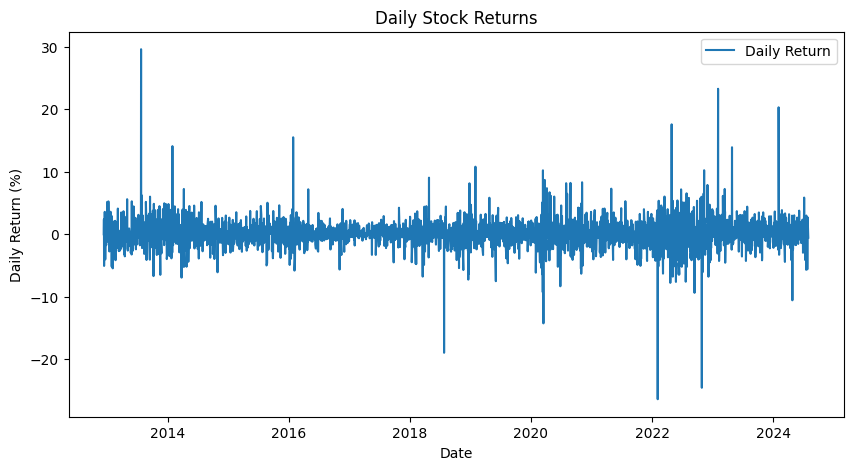

In [181]:


plt.figure(figsize=(10, 5))
plt.plot(stock_data['Date'], stock_data['daily_return'], label='Daily Return')
plt.title('Daily Stock Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.legend()
plt.show()


In [182]:
# Calculate the correlation between daily sentiment scores and daily stock returns
correlation, p_value = pearsonr(aligned_data['sentiment'], aligned_data['daily_return'])

# Display the results
print(f"Correlation between daily sentiment scores and stock returns: {correlation}")
print(f"P-value of the correlation: {p_value}")

ValueError: array must not contain infs or NaNs